In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")

print("Path to dataset files:", path)

shipsnet_path = path + r"\\shipsnet.json"

Path to dataset files: C:\Users\wwden\.cache\kagglehub\datasets\rhammell\ships-in-satellite-imagery\versions\9


In [2]:
import json

with open(shipsnet_path) as f:
    data = json.load(f)  # NOT json.dumps()

def print_structure(d, indent=0):
    prefix = '  ' * indent
    if isinstance(d, dict):
        for k, v in d.items():
            print(f"{prefix}{k}: {type(v).__name__}")
            print_structure(v, indent + 1)
    elif isinstance(d, list):
        print(f"{prefix}list[{len(d)}]: {type(d[0]).__name__}" if d else f"{prefix}list: empty")
        if d:
            print_structure(d[0], indent + 1)

print_structure(data)

data: list
  list[4000]: list
    list[19200]: int
labels: list
  list[4000]: int
locations: list
  list[4000]: list
    list[2]: float
scene_ids: list
  list[4000]: str


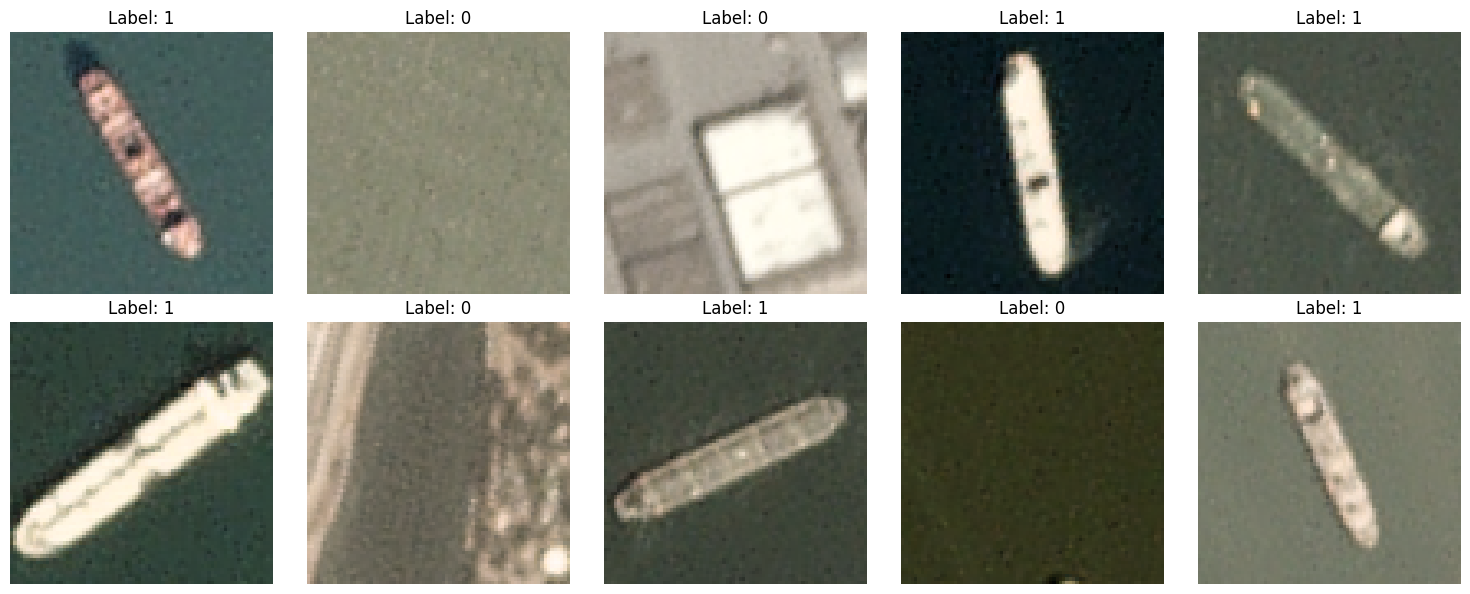

In [3]:
import numpy as np
import matplotlib.pyplot as plt

X_data = np.array(data["data"][:2000])
y_data = np.array(data["labels"][:2000])

X_data_transformed = X_data.reshape(-1, 3, 80, 80).transpose(0, 2, 3, 1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
indices = np.random.randint(0,2000,size = 10)

for ax, idx in zip(axes.flat, indices):
    ax.imshow(X_data_transformed[idx].astype(np.uint8))
    ax.set_title(f"Label: {y_data[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:
import os
import sys

# Save current working directory
cwd = os.getcwd()

# Change to parent directory
parent_dir = os.path.abspath(os.path.join(cwd, '..'))
os.chdir(parent_dir)

# Temporarily add parent directory to sys.path
sys.path.insert(0, parent_dir)
import framework
sys.path.pop(0)

# Return to original directory
os.chdir(cwd)


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from CNN import CNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

X_tensor = torch.tensor(X_data_transformed, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y_data, dtype=torch.long)

# Split indices
num_samples = X_tensor.size(0)
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size

indices = torch.randperm(num_samples)
train_idx, test_idx = indices[:train_size], indices[train_size:]

# Create splits
X_train, y_train = X_tensor[train_idx], y_tensor[train_idx]
X_test, y_test = X_tensor[test_idx], y_tensor[test_idx]

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CNN(F.relu, dropout_rate=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

best_loss = float('inf')

for epoch in range(1000):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples

    print(f"Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    if avg_loss > best_loss * 1.01:
        print("Stopping early due to loss increase")
        break

    best_loss = avg_loss

# Test evaluation
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)

test_accuracy = 100 * test_correct / test_samples
print(f"Test Accuracy: {test_accuracy:.2f}%")

cuda
Epoch 1 completed, Avg Loss: 1.2037, Accuracy: 69.44%
Epoch 2 completed, Avg Loss: 0.2096, Accuracy: 92.56%
Epoch 3 completed, Avg Loss: 0.1275, Accuracy: 95.88%
Epoch 4 completed, Avg Loss: 0.1025, Accuracy: 96.56%
Epoch 5 completed, Avg Loss: 0.0585, Accuracy: 98.19%
Epoch 6 completed, Avg Loss: 0.0570, Accuracy: 98.06%
Epoch 7 completed, Avg Loss: 0.0417, Accuracy: 98.94%
Epoch 8 completed, Avg Loss: 0.0529, Accuracy: 98.38%
Stopping early due to loss increase
Test Accuracy: 98.75%


In [6]:
from framework.attack import Injector
from framework.criterion import multiclass_classification_accuracy

pred = model(X_test.to(device))

baseline = multiclass_classification_accuracy(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
baseline

0.9875

In [7]:
crit = lambda a,b : multiclass_classification_accuracy(a.cpu().detach().numpy(), b.cpu().detach().numpy())

inj = Injector(model, X_test, y_test, crit, "cuda")

import pandas as pd
df = pd.DataFrame()
for bit in [0,1,3,6,10,15,21]:
    print(bit)

    results = inj.run_seu(bit,)

    res = pd.DataFrame(results)
    res["bit_i"] = bit
    df = pd.concat([df, res])

df

Testing a forward pass on cuda...
Basline Criterion Score: 0.9875
0


216it [00:01, 198.13it/s]
8it [00:00, 199.53it/s]
1152it [00:05, 195.58it/s]
16it [00:00, 198.60it/s]
4608it [00:23, 193.18it/s]
32it [00:00, 192.40it/s]
1600it [00:08, 189.36it/s]
2it [00:00, 120.19it/s]


1


216it [00:01, 185.10it/s]
8it [00:00, 172.23it/s]
1152it [00:06, 190.41it/s]
16it [00:00, 182.68it/s]
4608it [00:24, 187.11it/s]
32it [00:00, 182.41it/s]
1600it [00:08, 187.88it/s]
2it [00:00, 167.06it/s]


3


216it [00:01, 186.24it/s]
8it [00:00, 178.99it/s]
1152it [00:06, 184.93it/s]
16it [00:00, 192.34it/s]
4608it [00:25, 183.60it/s]
32it [00:00, 183.89it/s]
1600it [00:08, 183.42it/s]
2it [00:00, 194.49it/s]


6


216it [00:01, 183.03it/s]
8it [00:00, 183.57it/s]
1152it [00:06, 177.52it/s]
16it [00:00, 179.71it/s]
4608it [00:25, 178.40it/s]
32it [00:00, 165.41it/s]
1600it [00:09, 173.38it/s]
2it [00:00, 188.20it/s]


10


216it [00:01, 176.62it/s]
8it [00:00, 173.78it/s]
1152it [00:06, 177.06it/s]
16it [00:00, 178.36it/s]
4608it [00:26, 175.94it/s]
32it [00:00, 174.88it/s]
1600it [00:09, 175.87it/s]
2it [00:00, 173.84it/s]


15


216it [00:01, 170.80it/s]
8it [00:00, 177.74it/s]
1152it [00:06, 178.25it/s]
16it [00:00, 173.90it/s]
4608it [00:26, 175.88it/s]
32it [00:00, 171.86it/s]
1600it [00:09, 175.58it/s]
2it [00:00, 166.53it/s]


21


216it [00:01, 173.22it/s]
8it [00:00, 175.10it/s]
1152it [00:06, 175.12it/s]
16it [00:00, 178.57it/s]
4608it [00:24, 184.82it/s]
32it [00:00, 186.88it/s]
1600it [00:09, 172.77it/s]
2it [00:00, 151.94it/s]


,tensor_location,criterion_score,layer_name,value_before,value_after,bit_i
0,"(0, 0, 0, 0)",0.9375,conv1.weight,0.166510,-0.166510,0
1,"(0, 0, 0, 1)",0.9775,conv1.weight,-0.101200,0.101200,0
2,"(0, 0, 0, 2)",0.9700,conv1.weight,0.096936,-0.096936,0
3,"(0, 0, 1, 0)",0.9850,conv1.weight,-0.081685,0.081685,0
4,"(0, 0, 1, 1)",0.9850,conv1.weight,0.018271,-0.018271,0
...,...,...,...,...,...,...
7629,"(1, 797)",0.9875,fc1.weight,-0.005129,-0.005129,21
7630,"(1, 798)",0.9875,fc1.weight,-0.012342,-0.012341,21
7631,"(1, 799)",0.9875,fc1.weight,-0.012154,-0.012155,21
7632,"(0,)",0.9875,fc1.bias,0.008895,0.008896,21


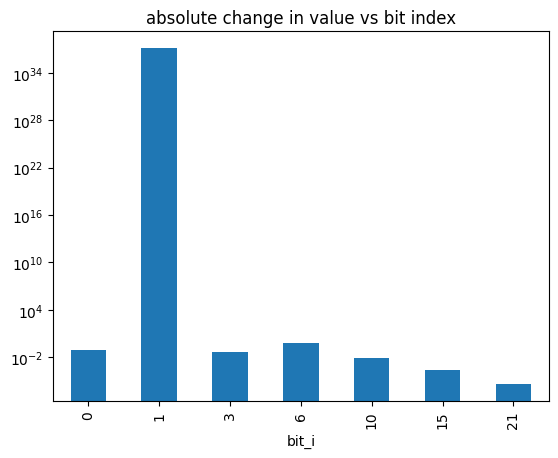

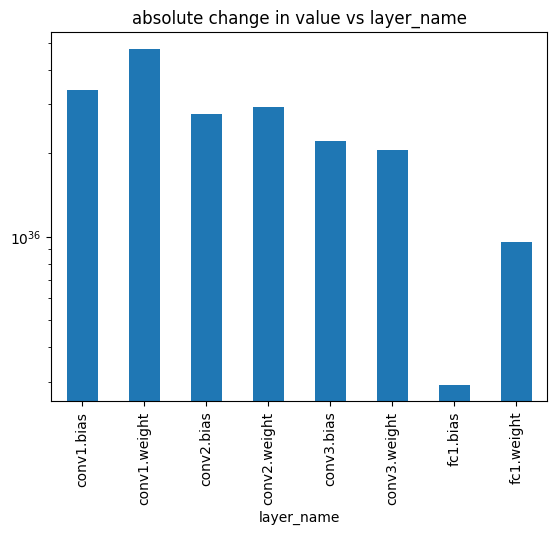

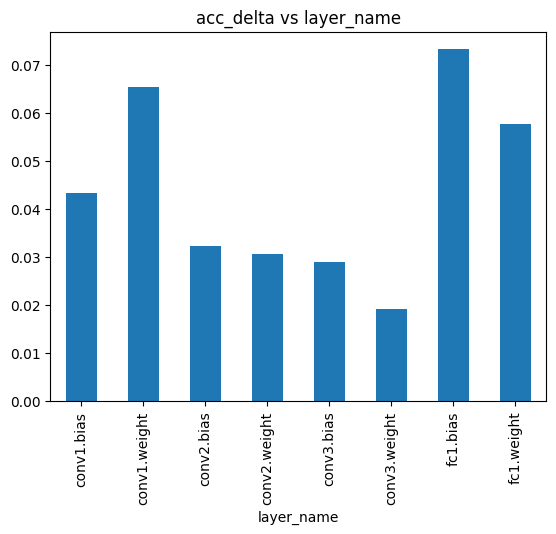

In [8]:
df["value_delta"] = abs(df["value_before"] - df["value_after"])
df["acc_delta"] = baseline - df["criterion_score"]
df.describe()

df.groupby("bit_i")["value_delta"].mean().plot(kind = "bar", title = "absolute change in value vs bit index")
plt.yscale("log")
plt.show()

df.groupby("layer_name")["value_delta"].mean().plot(kind = "bar", title = "absolute change in value vs layer_name")
plt.yscale("log")
plt.show()

df.groupby("layer_name")["acc_delta"].mean().plot(kind = "bar", title = "acc_delta vs layer_name")
plt.show()

In [10]:
df.to_parquet("results/shipsnet_relu_cnn.gzip", compression="gzip")